In [1]:

import pandas as pd
import numpy as np


import matplotlib.pyplot as plt
import seaborn as sns
%config InlineBackend.figure_formats = ['svg']
%matplotlib inline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.datasets import make_classification
from sklearn.metrics import classification_report,confusion_matrix,plot_confusion_matrix
from sklearn.metrics import roc_curve , roc_auc_score
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier
from collections import Counter
from imblearn.over_sampling import RandomOverSampler,SMOTE,ADASYN
from sklearn.model_selection import train_test_split, KFold, cross_val_score, StratifiedKFold

#Import all the models that I will use
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier, VotingClassifier
import xgboost as xgb

In [2]:
train_df = pd.read_csv('census_encoded.csv',index_col=0)
test_df = pd.read_csv('census_test_encoded.csv',index_col=0)

In [3]:
train_df.shape,test_df.shape

((140989, 139), (70702, 139))

In [4]:
X_train = train_df.drop(columns=['income'])
y_train = train_df['income']
X_test = test_df.drop(columns=['income'])
y_test = test_df['income']

## Baseline Models

In [5]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42, stratify=y_train)

#### kNN

In [6]:
knn = KNeighborsClassifier(n_neighbors=10)
knn.fit(X_train,y_train)
y_pred = knn.predict(X_val)
print("Training set: ", knn.score(X_train, y_train))
print("Test set: ", knn.score(X_val, y_val))
print(classification_report(y_val, y_pred))

Training set:  0.928531531771152
Test set:  0.9209163770480175
              precision    recall  f1-score   support

           0       0.93      0.99      0.96     25722
           1       0.66      0.21      0.32      2476

    accuracy                           0.92     28198
   macro avg       0.79      0.60      0.64     28198
weighted avg       0.90      0.92      0.90     28198



kNN has very good scores but is suffering from the class imbalance issue I will now try kNN with a few different blancing techniques to ee how it performs

In [64]:
def make_heatmap(y_test, y_pred, model_name):
    plt.figure(figsize=(8, 8))
    conf_matrix = confusion_matrix(y_test, y_pred, normalize="all")
    sns.heatmap((conf_matrix*100), annot=True, square=True)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("{} Confusion Matrix".format(model_name))
    plt.savefig('{}.png'.format(model_name));

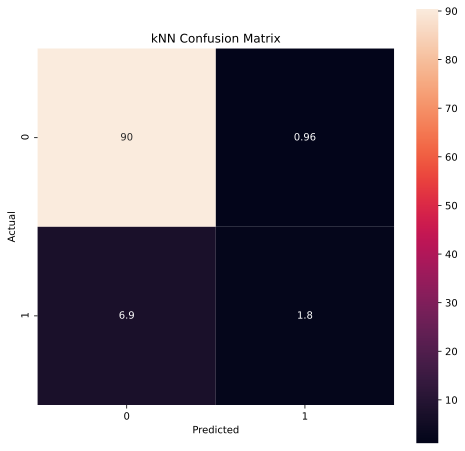

In [8]:
make_heatmap(y_val,y_pred,'kNN')

In [9]:
X_smote, y_smote = SMOTE(random_state=42).fit_sample(X_train, y_train)
knn.fit(X_smote,y_smote)
y_pred = knn.predict(X_val)
print("Training set: ", knn.score(X_smote, y_smote))
print("Test set: ", knn.score(X_val, y_val))
print(classification_report(y_val, y_pred))

Training set:  0.9045807091205972
Test set:  0.7979643946379176
              precision    recall  f1-score   support

           0       0.97      0.81      0.88     25722
           1       0.26      0.71      0.38      2476

    accuracy                           0.80     28198
   macro avg       0.61      0.76      0.63     28198
weighted avg       0.90      0.80      0.84     28198



#### SMOTE seems to still be overfitting on the test data will try a new balancing technique

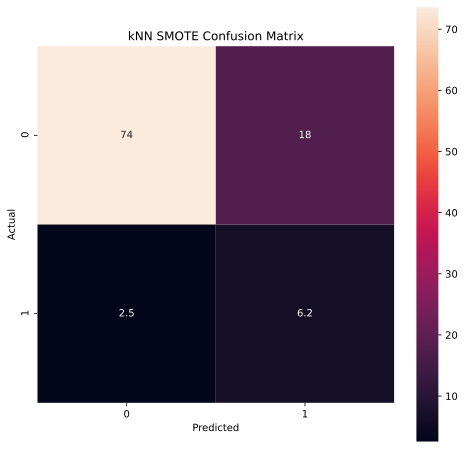

In [10]:
make_heatmap(y_val,y_pred,'kNN SMOTE')

In [11]:
X_ROS, y_ROS = RandomOverSampler(random_state=42).fit_sample(X_train, y_train)
knn.fit(X_ROS,y_ROS)
y_pred = knn.predict(X_val)
print("Training set: ", knn.score(X_ROS, y_ROS))
print("Test set: ", knn.score(X_val, y_val))
print(classification_report(y_val, y_pred))

Training set:  0.9072243604696368
Test set:  0.7808000567416129
              precision    recall  f1-score   support

           0       0.97      0.79      0.87     25722
           1       0.25      0.72      0.37      2476

    accuracy                           0.78     28198
   macro avg       0.61      0.75      0.62     28198
weighted avg       0.90      0.78      0.82     28198



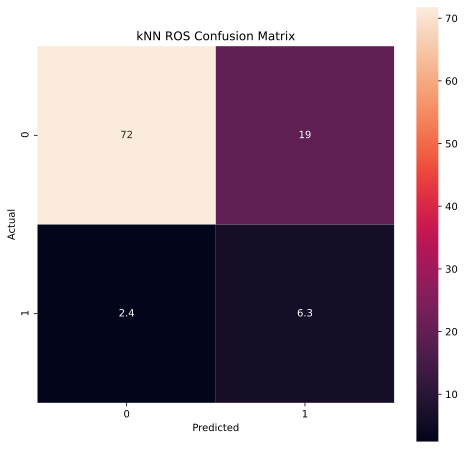

In [12]:
make_heatmap(y_val,y_pred,'kNN ROS')

In [13]:
X_adasyn, y_adasyn = ADASYN(sampling_strategy="minority", random_state=42).fit_sample(X_train, y_train)
knn.fit(X_adasyn,y_adasyn)
y_pred = knn.predict(X_val)
print("Training set: ", knn.score(X_adasyn, y_adasyn))
print("Test set: ", knn.score(X_val, y_val))
print(classification_report(y_val, y_pred))

Training set:  0.8948227500311133
Test set:  0.7715440811405064
              precision    recall  f1-score   support

           0       0.97      0.77      0.86     25722
           1       0.24      0.74      0.36      2476

    accuracy                           0.77     28198
   macro avg       0.60      0.76      0.61     28198
weighted avg       0.90      0.77      0.82     28198



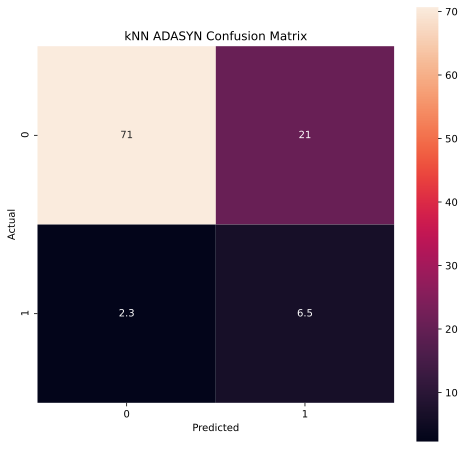

In [14]:
make_heatmap(y_val,y_pred,'kNN ADASYN')

## Try Different models w/ different sampling techniques
### Random Oversampling

In [7]:
def get_metrics(X,y,X_test,y_test,model,name,sampler,sampler_name):
    X_resampled,y_resampled = sampler.fit_sample(X,y)
    model = model.fit(X_resampled,y_resampled)
    y_pred = model.predict(X_test)
    print('{} train score: {:.3f}'.format(name,model.score(X_resampled,y_resampled)))
    print('{} test score: {:.3f}'.format( name, model.score(X_test,y_test)))
    print(classification_report(y_test, y_pred))
    make_heatmap(y_test,y_pred,'{} + {}'.format(name,sampler_name))
    return model

In [8]:
X_train,X_val,y_train,y_val = train_test_split(X_train,y_train,test_size = 0.3,stratify=y_train)

In [9]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

scaler.fit(X_train)

X_train_scaled = scaler.transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

#### Logistic Regression

/Users/sibongiletoure/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LR train score: 0.839
LR test score: 0.830
              precision    recall  f1-score   support

           0       0.98      0.83      0.90     30867
           1       0.32      0.85      0.47      2971

    accuracy                           0.83     33838
   macro avg       0.65      0.84      0.68     33838
weighted avg       0.92      0.83      0.86     33838



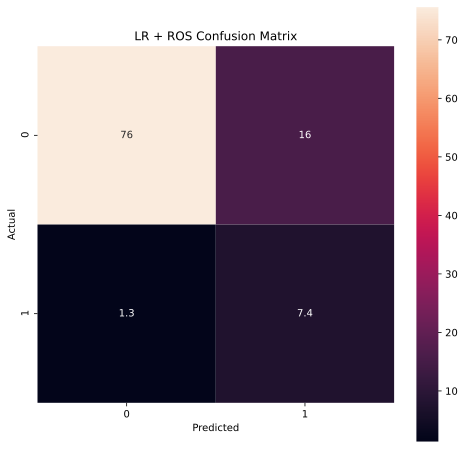

In [65]:
lr = get_metrics(X_train_scaled,y_train,X_val_scaled,y_val,LogisticRegression(penalty='none'),'LR',RandomOverSampler(random_state=42),'ROS')

### GaussianNB

nb train score: 0.735
nb test score: 0.597
              precision    recall  f1-score   support

           0       0.99      0.57      0.72     30867
           1       0.17      0.91      0.28      2971

    accuracy                           0.60     33838
   macro avg       0.58      0.74      0.50     33838
weighted avg       0.91      0.60      0.68     33838



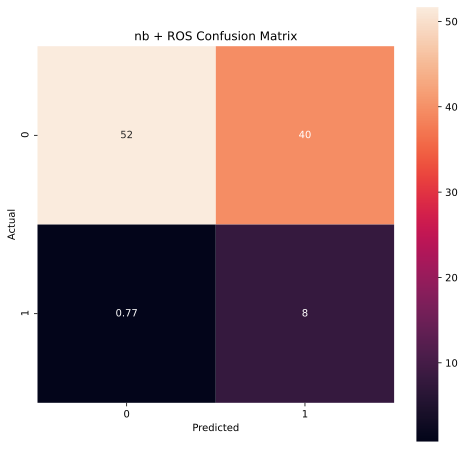

In [11]:
nb = get_metrics(X_train_scaled,y_train,X_val_scaled,y_val,GaussianNB(),'nb',RandomOverSampler(random_state=42),'ROS')

#### Decision Tree

dt train score: 1.000
dt test score: 0.902
              precision    recall  f1-score   support

           0       0.95      0.95      0.95     30867
           1       0.44      0.44      0.44      2971

    accuracy                           0.90     33838
   macro avg       0.69      0.69      0.69     33838
weighted avg       0.90      0.90      0.90     33838



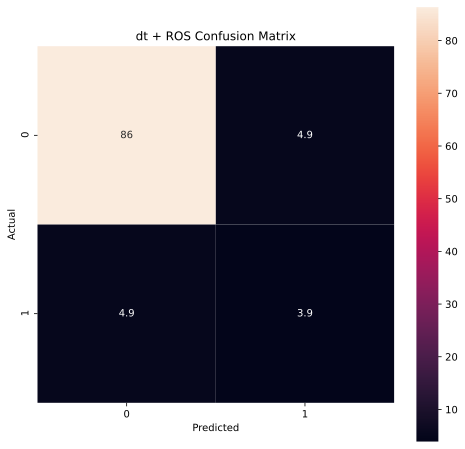

In [20]:
dt = get_metrics(X_train_scaled,y_train,X_val_scaled,y_val,DecisionTreeClassifier(random_state=0),'dt',RandomOverSampler(random_state=42),'ROS')

### Use a grid search to try and fine tune the decision tree to minimize the overfitting

In [21]:
param_grid = {
    'max_depth': range(0,11),
    'min_samples_leaf': range(0,101),
}
dt =DecisionTreeClassifier()


grid_search = GridSearchCV(estimator = dt, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)

grid_search.fit(X_train_scaled, y_train)

grid_search.best_params_

Fitting 3 folds for each of 1111 candidates, totalling 3333 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    4.0s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:    7.5s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:   15.0s
[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed:   33.3s
[Parallel(n_jobs=-1)]: Done 997 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 1442 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 1969 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done 2576 tasks      | elapsed:  5.7min
[Parallel(n_jobs=-1)]: Done 3265 tasks      | elapsed:  8.5min
[Parallel(n_jobs=-1)]: Done 3333 out of 3333 | elapsed:  8.8min finished


{'max_depth': 10, 'min_samples_leaf': 24}

dt train score: 0.851
dt test score: 0.825
              precision    recall  f1-score   support

           0       0.98      0.83      0.90     30867
           1       0.31      0.82      0.45      2971

    accuracy                           0.83     33838
   macro avg       0.65      0.82      0.67     33838
weighted avg       0.92      0.83      0.86     33838



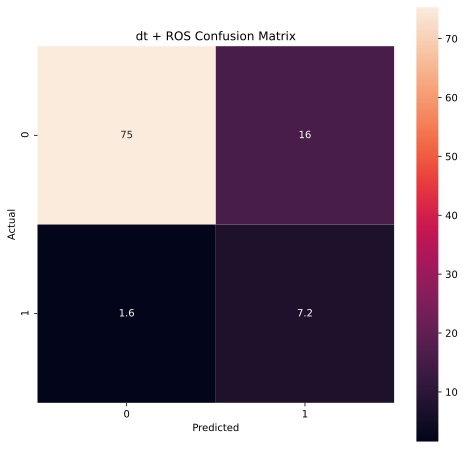

In [12]:
dt = get_metrics(X_train_scaled,y_train,X_val_scaled,y_val,DecisionTreeClassifier(max_depth=10,min_samples_leaf=24),'dt',RandomOverSampler(random_state=42),'ROS')

### RandomForest

In [23]:
param_grid = {
    'max_depth': range(0,11),
    'min_samples_leaf': range(0,101),
}
rf =RandomForestClassifier()


grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)

grid_search.fit(X_train_scaled, y_train)

grid_search.best_params_

Fitting 3 folds for each of 1111 candidates, totalling 3333 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:    5.8s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:   27.6s
[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 997 tasks      | elapsed:  5.4min
[Parallel(n_jobs=-1)]: Done 1442 tasks      | elapsed: 11.0min
[Parallel(n_jobs=-1)]: Done 1969 tasks      | elapsed: 19.7min
[Parallel(n_jobs=-1)]: Done 2576 tasks      | elapsed: 32.1min
[Parallel(n_jobs=-1)]: Done 3265 tasks      | elapsed: 49.1min
[Parallel(n_jobs=-1)]: Done 3333 out of 3333 | elapsed: 50.8min finished


{'max_depth': 10, 'min_samples_leaf': 2}

rf train score: 0.856
rf test score: 0.825
              precision    recall  f1-score   support

           0       0.98      0.82      0.90     30867
           1       0.32      0.85      0.46      2971

    accuracy                           0.83     33838
   macro avg       0.65      0.84      0.68     33838
weighted avg       0.92      0.83      0.86     33838



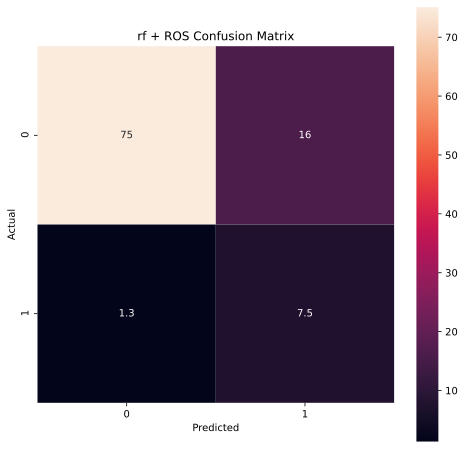

In [13]:
rf = get_metrics(X_train_scaled,y_train,X_val_scaled,y_val,RandomForestClassifier(max_depth=10,min_samples_leaf=2),'rf',RandomOverSampler(random_state=42),'ROS')

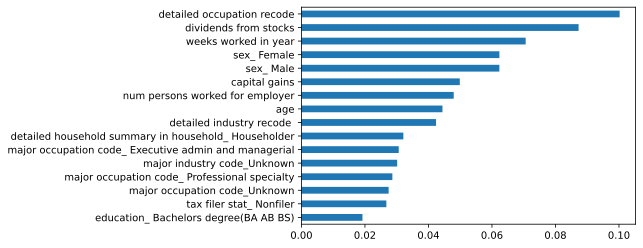

In [14]:
(pd.Series(rf.feature_importances_, index=X_train.columns)
   .nlargest(16)
   .plot(kind='barh')).invert_yaxis()

In [15]:
model_names = ["lr","nb","rf",'dt']

model_vars = [eval(n) for n in model_names]
model_list = list(zip(model_names, model_vars))

In [16]:
for model_name in model_names:
    curr_model = eval(model_name)
    print(f'{model_name} score: {curr_model.score(X_val_scaled, y_val)}')

lr score: 0.8299249364619659
nb score: 0.5965482593533897
rf score: 0.8254329452095277
dt score: 0.8252260771913233


### XGBoost

In [33]:
X_ROS, y_ROS = RandomOverSampler(random_state=42).fit_sample(X_train, y_train)

In [34]:
gbm = xgb.XGBClassifier( 
                        n_estimators=10000,
                        max_depth=4,
                        objective='binary:logistic', 
                        learning_rate=.05, 
                        subsample=.8,
                        min_child_weight=3,
                        colsample_bytree=.8
                       )

eval_set=[(X_ROS,y_ROS),(X_val,y_val)]
fit_model = gbm.fit( 
                    X_ROS, y_ROS, 
                    eval_set=eval_set,
                    eval_metric='auc', 
                    early_stopping_rounds=50,
                    verbose=False
                   )
print('XGBoost train score: {:.3f}'.format(accuracy_score(y_ROS, gbm.predict(X_ROS, ntree_limit=gbm.best_ntree_limit))))
print('XGBoost val score: {:.3f}'.format(accuracy_score(y_val, gbm.predict(X_val, ntree_limit=gbm.best_ntree_limit))))
print(classification_report(y_val, gbm.predict(X_val, ntree_limit=gbm.best_ntree_limit)))

XGBoost train score: 0.882
XGBoost val score: 0.867
              precision    recall  f1-score   support

           0       0.98      0.87      0.92     30867
           1       0.38      0.84      0.53      2971

    accuracy                           0.87     33838
   macro avg       0.68      0.85      0.72     33838
weighted avg       0.93      0.87      0.89     33838



## ROC AUC

In [20]:
fpr_log, tpr_log, thresholds_log = roc_curve(y_val, lr.predict_proba(X_val_scaled)[:,1])
fpr_nb, tpr_nb, thresholds_nb = roc_curve(y_val, nb.predict_proba(X_val_scaled)[:,1])
fpr_rf, tpr_rf, thresholds_rf = roc_curve(y_val, rf.predict_proba(X_val_scaled)[:,1])
fpr_dt, tpr_dt, thresholds_dt = roc_curve(y_val, dt.predict_proba(X_val_scaled)[:,1])
fpr_gbm,tpr_gbm,thresholds_gbm = roc_curve(y_val, gbm.predict_proba(X_val)[:,1])

Logit ROC AUC score =  0.916198569519938
Naive Bayes ROC AUC score =  0.8208922468278117
Random Forest ROC AUC score =  0.913537305474393
Decision Tree ROC AUC score =  0.8962375380233348
XgBoost ROC AUC score =  0.9336928610786549


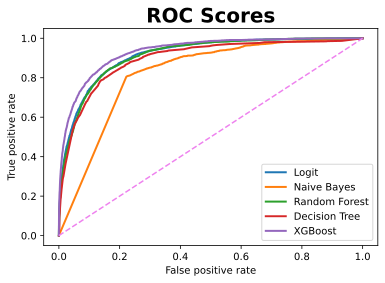

In [21]:
#plt.plot(fpr_knn, tpr_knn,lw=2)
plt.plot(fpr_log, tpr_log,lw=2)
plt.plot(fpr_nb, tpr_nb,lw=2)
plt.plot(fpr_rf, tpr_rf,lw=2)
#plt.plot(fpr_svc, tpr_svc,lw=2)
plt.plot(fpr_dt, tpr_dt,lw=2)
#plt.plot(fpr_vc, tpr_vc,lw=2)
plt.plot(fpr_gbm, tpr_gbm,lw=2)
plt.plot([0,1],[0,1],c='violet',ls='--')
plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC Scores', fontweight='bold', fontsize=20);
plt.legend(['Logit', 'Naive Bayes', 'Random Forest', 'Decision Tree','XGBoost'])
#print('KNN ROC AUC score = ', roc_auc_score(y_val, knn.predict_proba(X_val_scaled)[:,1]))
print('Logit ROC AUC score = ', roc_auc_score(y_val, lr.predict_proba(X_val_scaled)[:,1]))
print('Naive Bayes ROC AUC score = ', roc_auc_score(y_val, nb.predict_proba(X_val_scaled)[:,1]))
print('Random Forest ROC AUC score = ', roc_auc_score(y_val, rf.predict_proba(X_val_scaled)[:,1]))
#print('Support Vector Machines ROC AUC score = ', roc_auc_score(y_val, svc.predict_proba(X_val_scaled)[:,1]))
print('Decision Tree ROC AUC score = ', roc_auc_score(y_val, dt.predict_proba(X_val_scaled)[:,1]))
#print('Voting Classifier ROC AUC score = ', roc_auc_score(y_val, avg_voting.predict_proba(X_val_scaled)[:,1]))
print('XgBoost ROC AUC score = ', roc_auc_score(y_val, gbm.predict_proba(X_val)[:,1]))

## ADASYN

#### Logistic regression

/Users/sibongiletoure/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LR train score: 0.833
LR test score: 0.814
              precision    recall  f1-score   support

           0       0.98      0.81      0.89     30867
           1       0.30      0.86      0.45      2971

    accuracy                           0.81     33838
   macro avg       0.64      0.84      0.67     33838
weighted avg       0.92      0.81      0.85     33838



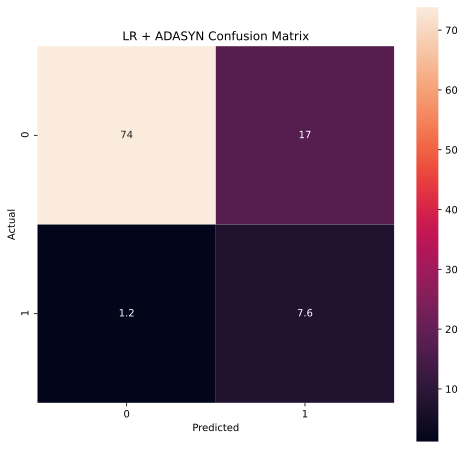

In [22]:
lr = get_metrics(X_train_scaled,y_train,X_val_scaled,y_val,LogisticRegression(penalty='none'),'LR',ADASYN(sampling_strategy="minority", random_state=42),'ADASYN')

#### NaiveBayes

nb train score: 0.724
nb test score: 0.573
              precision    recall  f1-score   support

           0       0.99      0.54      0.70     30867
           1       0.16      0.92      0.27      2971

    accuracy                           0.57     33838
   macro avg       0.57      0.73      0.49     33838
weighted avg       0.91      0.57      0.66     33838



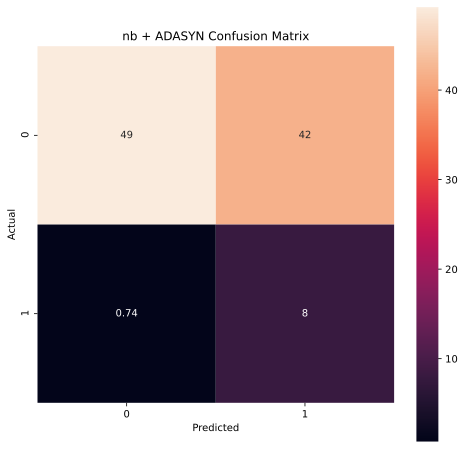

In [23]:
nb = get_metrics(X_train_scaled,y_train,X_val_scaled,y_val,GaussianNB(),'nb',ADASYN(sampling_strategy="minority", random_state=42),'ADASYN')

#### DecisionTree

In [57]:
param_grid = {
    'max_depth': range(0,11),
    'min_samples_leaf': range(0,101),
}
dt =DecisionTreeClassifier()


grid_search = GridSearchCV(estimator = dt, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)

grid_search.fit(X_train_scaled, y_train)

grid_search.best_params_

Fitting 3 folds for each of 1111 candidates, totalling 3333 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    4.1s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:    8.4s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:   16.9s
[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed:   36.5s
[Parallel(n_jobs=-1)]: Done 997 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 1442 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 1969 tasks      | elapsed:  4.1min
[Parallel(n_jobs=-1)]: Done 2576 tasks      | elapsed:  6.5min
[Parallel(n_jobs=-1)]: Done 3265 tasks      | elapsed:  9.8min
[Parallel(n_jobs=-1)]: Done 3333 out of 3333 | elapsed: 10.1min finished


{'max_depth': 9, 'min_samples_leaf': 19}

dt train score: 0.891
dt test score: 0.871
              precision    recall  f1-score   support

           0       0.97      0.89      0.93     30867
           1       0.37      0.70      0.49      2971

    accuracy                           0.87     33838
   macro avg       0.67      0.79      0.71     33838
weighted avg       0.92      0.87      0.89     33838



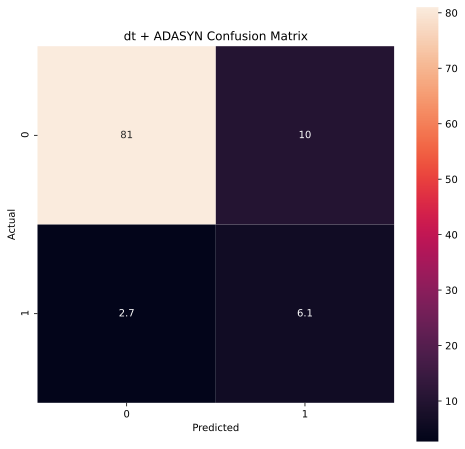

In [24]:
dt = get_metrics(X_train_scaled,y_train,X_val_scaled,y_val,DecisionTreeClassifier(max_depth=9,min_samples_leaf=19),'dt',ADASYN(sampling_strategy="minority", random_state=42),'ADASYN')

#### RandomForrest

In [26]:
param_grid = {
    'max_depth': range(0,11),
    'min_samples_leaf': range(0,101),
}
rf =RandomForestClassifier()


grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)

grid_search.fit(X_train_scaled, y_train)

grid_search.best_params_

Fitting 3 folds for each of 1111 candidates, totalling 3333 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:    5.9s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:   30.2s
[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 997 tasks      | elapsed:  6.0min
[Parallel(n_jobs=-1)]: Done 1442 tasks      | elapsed: 12.2min
[Parallel(n_jobs=-1)]: Done 1969 tasks      | elapsed: 23.2min
[Parallel(n_jobs=-1)]: Done 2576 tasks      | elapsed: 37.9min
[Parallel(n_jobs=-1)]: Done 3265 tasks      | elapsed: 57.5min
[Parallel(n_jobs=-1)]: Done 3333 out of 3333 | elapsed: 59.5min finished


{'max_depth': 10, 'min_samples_leaf': 2}

rf train score: 0.906
rf test score: 0.864
              precision    recall  f1-score   support

           0       0.97      0.88      0.92     30867
           1       0.36      0.73      0.49      2971

    accuracy                           0.86     33838
   macro avg       0.67      0.81      0.70     33838
weighted avg       0.92      0.86      0.88     33838



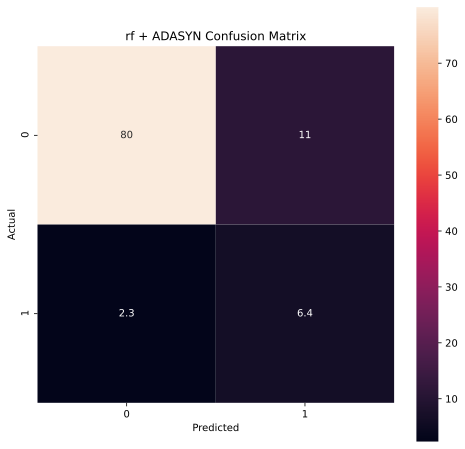

In [25]:
rf = get_metrics(X_train_scaled,y_train,X_val_scaled,y_val,RandomForestClassifier(max_depth=10,min_samples_leaf=2),'rf',ADASYN(sampling_strategy="minority", random_state=42),'ADASYN')

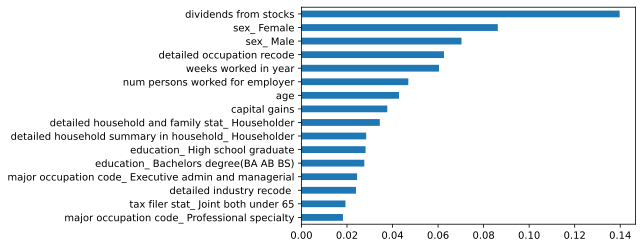

In [26]:
(pd.Series(rf.feature_importances_, index=X_train.columns)
   .nlargest(16)
   .plot(kind='barh')).invert_yaxis()

### XGBoost

In [27]:
X_adasyn, y_adasyn = ADASYN(sampling_strategy="minority", random_state=42).fit_sample(X_train, y_train)

In [28]:
gbm = xgb.XGBClassifier( 
                        n_estimators=10000,
                        max_depth=4,
                        objective='binary:logistic', 
                        learning_rate=.05, 
                        subsample=.8,
                        min_child_weight=3,
                        colsample_bytree=.8
                       )

eval_set=[(X_adasyn,y_adasyn),(X_val,y_val)]
fit_model = gbm.fit( 
                    X_adasyn, y_adasyn, 
                    eval_set=eval_set,
                    eval_metric='auc', 
                    early_stopping_rounds=50,
                    verbose=False
                   )
print('XGBoost train score: {:.3f}'.format(accuracy_score(y_adasyn, gbm.predict(X_adasyn, ntree_limit=gbm.best_ntree_limit))))
print('XGBoost val score: {:.3f}'.format(accuracy_score(y_val, gbm.predict(X_val, ntree_limit=gbm.best_ntree_limit))))
print(classification_report(y_val, gbm.predict(X_val, ntree_limit=gbm.best_ntree_limit)))

XGBoost train score: 0.970
XGBoost val score: 0.938
              precision    recall  f1-score   support

           0       0.95      0.98      0.97     30867
           1       0.73      0.47      0.57      2971

    accuracy                           0.94     33838
   macro avg       0.84      0.73      0.77     33838
weighted avg       0.93      0.94      0.93     33838



## ROC AUC

In [29]:
fpr_log, tpr_log, thresholds_log = roc_curve(y_val, lr.predict_proba(X_val_scaled)[:,1])
fpr_nb, tpr_nb, thresholds_nb = roc_curve(y_val, nb.predict_proba(X_val_scaled)[:,1])
fpr_rf, tpr_rf, thresholds_rf = roc_curve(y_val, rf.predict_proba(X_val_scaled)[:,1])
fpr_dt, tpr_dt, thresholds_dt = roc_curve(y_val, dt.predict_proba(X_val_scaled)[:,1])

Logit ROC AUC score =  0.9139168286710411
Naive Bayes ROC AUC score =  0.8125524632521564
Random Forest ROC AUC score =  0.9034760615126252
Decision Tree ROC AUC score =  0.8817751684060919


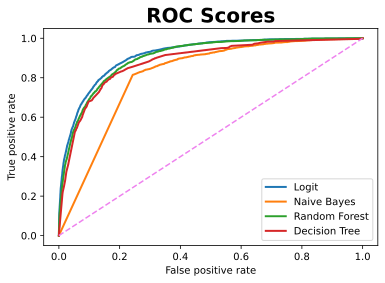

In [30]:
#plt.plot(fpr_knn, tpr_knn,lw=2)
plt.plot(fpr_log, tpr_log,lw=2)
plt.plot(fpr_nb, tpr_nb,lw=2)
plt.plot(fpr_rf, tpr_rf,lw=2)
#plt.plot(fpr_svc, tpr_svc,lw=2)
plt.plot(fpr_dt, tpr_dt,lw=2)
#plt.plot(fpr_vc, tpr_vc,lw=2)
#plt.plot(fpr_gbm, tpr_gbm,lw=2)
plt.plot([0,1],[0,1],c='violet',ls='--')
plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC Scores', fontweight='bold', fontsize=20);
plt.legend(['Logit', 'Naive Bayes', 'Random Forest', 'Decision Tree'])
#print('KNN ROC AUC score = ', roc_auc_score(y_val, knn.predict_proba(X_val_scaled)[:,1]))
print('Logit ROC AUC score = ', roc_auc_score(y_val, lr.predict_proba(X_val_scaled)[:,1]))
print('Naive Bayes ROC AUC score = ', roc_auc_score(y_val, nb.predict_proba(X_val_scaled)[:,1]))
print('Random Forest ROC AUC score = ', roc_auc_score(y_val, rf.predict_proba(X_val_scaled)[:,1]))
#print('Support Vector Machines ROC AUC score = ', roc_auc_score(y_val, svc.predict_proba(X_val_scaled)[:,1]))
print('Decision Tree ROC AUC score = ', roc_auc_score(y_val, dt.predict_proba(X_val_scaled)[:,1]))
#print('Voting Classifier ROC AUC score = ', roc_auc_score(y_val, avg_voting.predict_proba(X_val_scaled)[:,1]))
#print('XgBoost ROC AUC score = ', roc_auc_score(y_resampled_val, gbm.predict_proba(X_resampled_val)[:,1]))

## Final Model Selection
* For the final model I will pick the XGBoost with ROS. 

In [38]:
print('XGBoost test score: {:.3f}'.format(accuracy_score(y_test, gbm.predict(X_test, ntree_limit=gbm.best_ntree_limit))))

XGBoost test score: 0.863


In [39]:
fpr_gbm,tpr_gbm,thresholds_gbm = roc_curve(y_test, gbm.predict_proba(X_test)[:,1])

XgBoost ROC AUC score =  0.9296473563040886


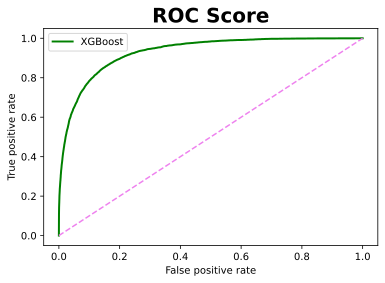

In [57]:
plt.plot(fpr_gbm, tpr_gbm,lw=2,color='green')
plt.plot([0,1],[0,1],c='violet',ls='--')
plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC Score', fontweight='bold', fontsize=20);
plt.legend(['XGBoost'])
print('XgBoost ROC AUC score = ', roc_auc_score(y_test, gbm.predict_proba(X_test)[:,1]))

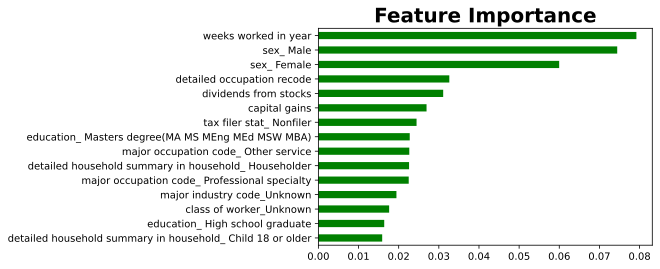

In [60]:
(pd.Series(gbm.feature_importances_, index=X_train.columns)
   .nlargest(15)
   .plot(kind='barh',color='green')).invert_yaxis()
plt.title('Feature Importance', fontweight='bold', fontsize=20);